In [29]:
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import os
from tqdm import tqdm

def get_dominant_colors(image_path, k=5):
    img = Image.open(image_path).convert("RGB").resize((300, 300))
    pixels = np.array(img).reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)
    return kmeans.cluster_centers_.astype(int)

frame_dirs = ['study_me_frames', 
              'cream_frames',
              'kuzuri_frames', 
              'hippo_pain_frames', 
              'truth_in_lies_frames', 
              'mirror_tune_frames', 
              'milabo_frames', 
              'time_left_frames',
              'hanaichi_frames', 
              'inside_joke_frames', 
              'justice_frames']

mv_frame_centroids = []
mv_colors = []

for frame_dir in frame_dirs:
    frame_centroids = []
    all_colors = []

    for fname in tqdm(sorted(os.listdir(frame_dir))):
        path = os.path.join(frame_dir, fname)
        try:
            colors = get_dominant_colors(path, k=7)
            avg_color = np.mean(colors, axis=0)
            frame_centroids.append((avg_color, path))
            all_colors.extend(colors)
        except:
            continue

    mv_frame_centroids.append(frame_centroids)
    mv_colors.append(all_colors)

 96%|███████████████████████████████████████▍ | 278/289 [00:22<00:00, 13.27it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 99%|████████████████████████████████████████▋| 287/289 [00:22<00:00, 15.93it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 96%|███████████████████████████████████████▎ | 187/195 [00:16<00:00,  9.78it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 99%|███████████████████████████████████

In [84]:
def reduce_palette(colors, final_k=12):
    kmeans = KMeans(n_clusters=final_k, random_state=1).fit(colors)
    return kmeans.cluster_centers_.astype(int)

final_palettes = []
for all_colors in mv_colors:
    palette = reduce_palette(all_colors, final_k=10)
    final_palettes.append(palette)

In [85]:
def get_representative_frames(frame_centroids, num_clusters=5):

    def brightness(rgb):
        # Perceived luminance formula
        return 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    
    filtered = [(c, p) for (c, p) in frame_centroids if (brightness(c) > 80) & (brightness(c) < 170)]

    if len(filtered) < num_clusters:
        filtered = frame_centroids
        
    colors = np.array([fc[0] for fc in filtered])
    paths = [fc[1] for fc in filtered]

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    labels = kmeans.fit_predict(colors)

    representatives = []
    
    for cluster_idx in range(0, num_clusters):
        # Get all indices in this cluster
        indices = np.where(labels == cluster_idx)[0]
        cluster_colors = colors[indices]
        cluster_paths = [paths[i] for i in indices]
        center = kmeans.cluster_centers_[cluster_idx]

        # Find the closest frame to the cluster center
        dists = np.linalg.norm(cluster_colors - center, axis=1)
        closest_idx = indices[np.argmin(dists)]
        representatives.append(paths[closest_idx])

    return representatives

mv_repr_paths = []
for i in range(0, len(final_palettes)):
    repr_paths = get_representative_frames(mv_frame_centroids[i], num_clusters=5)
    mv_repr_paths.append(repr_paths)

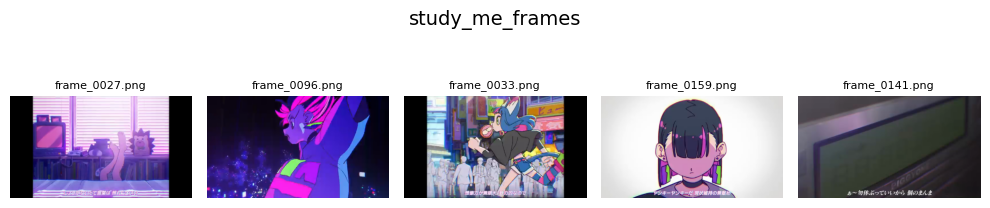

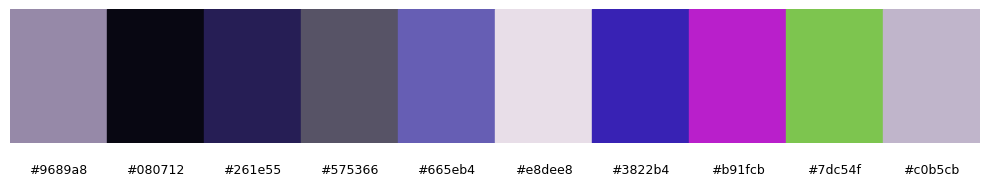

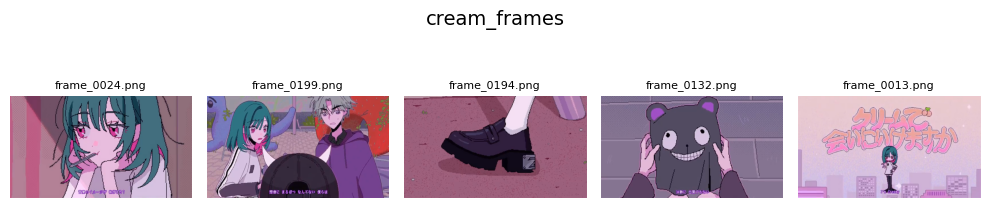

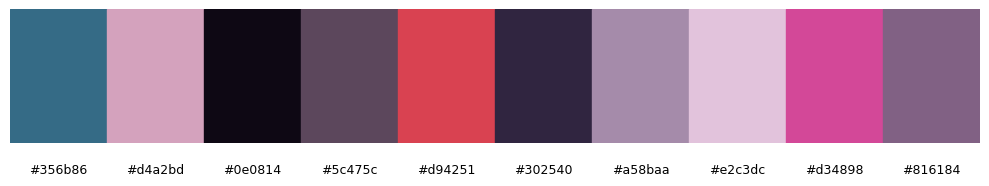

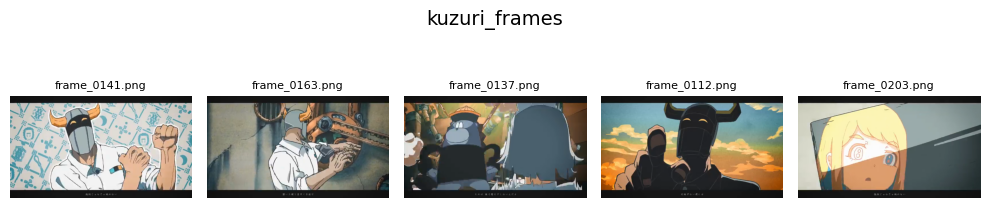

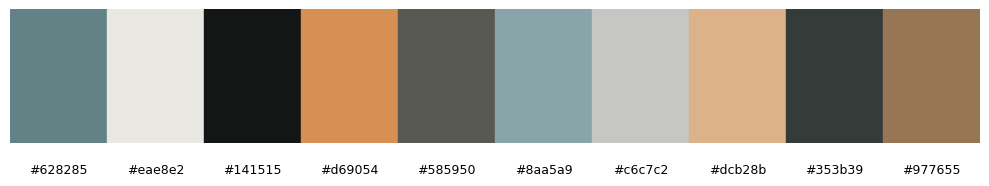

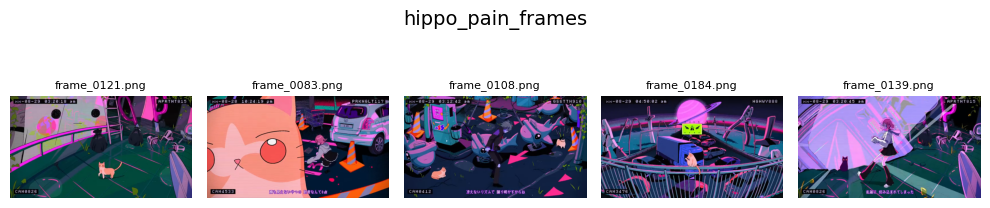

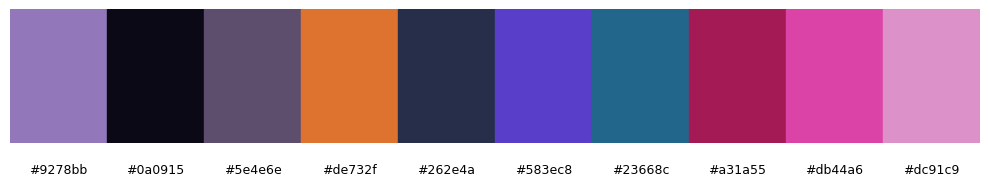

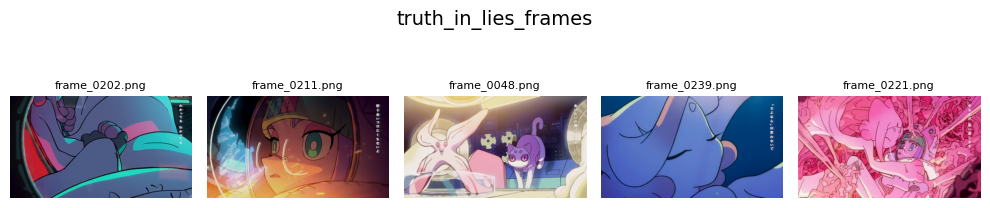

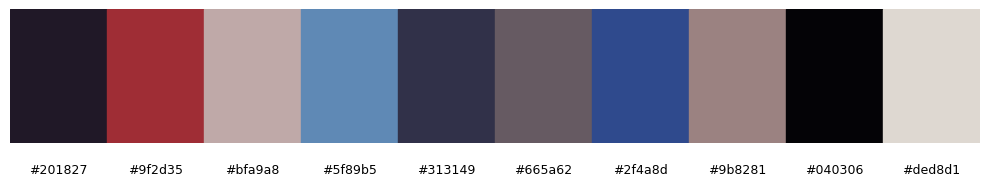

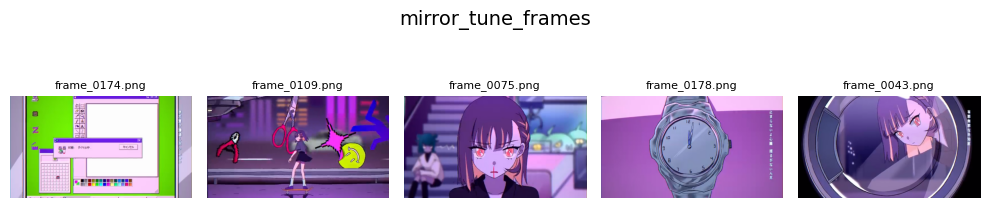

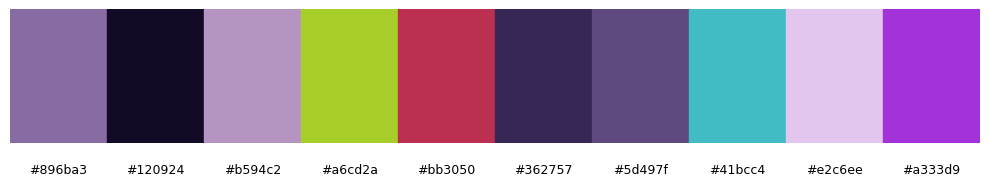

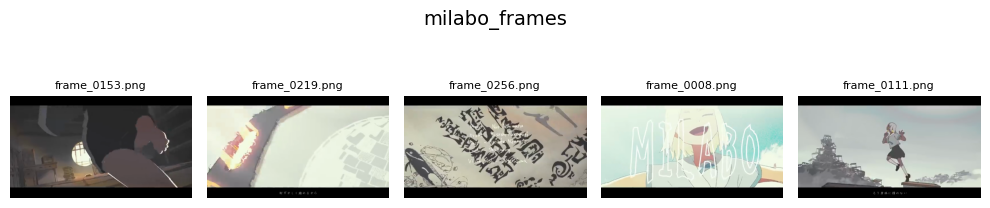

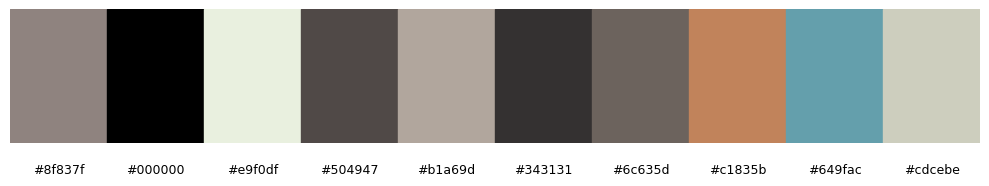

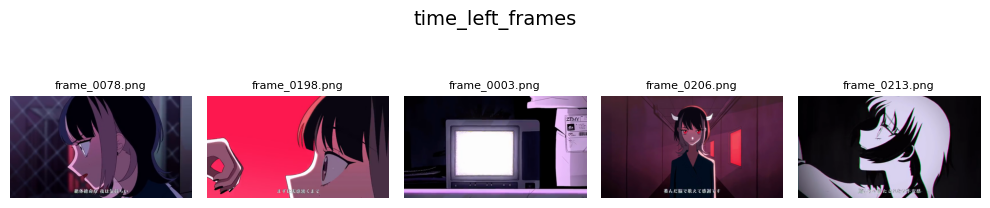

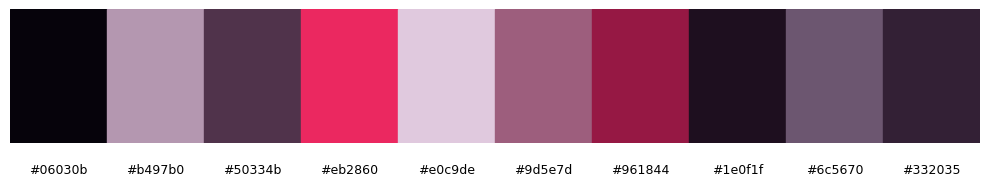

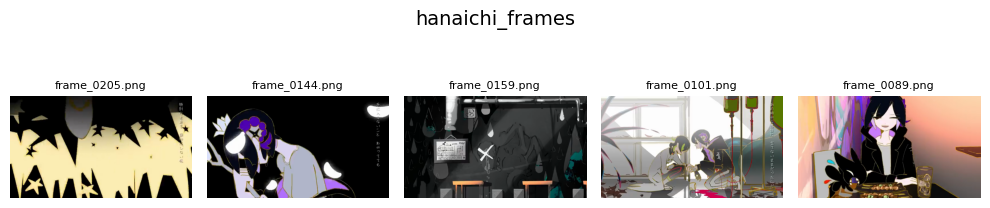

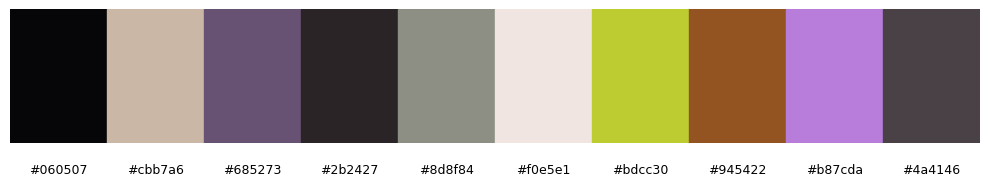

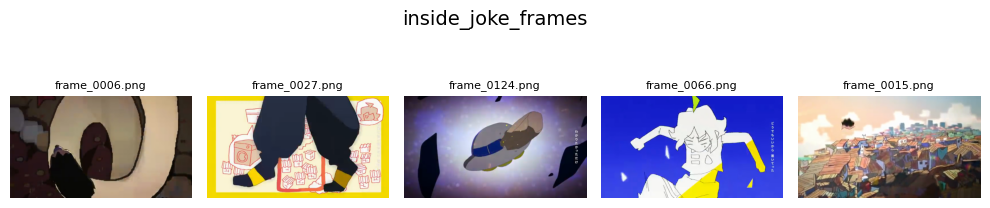

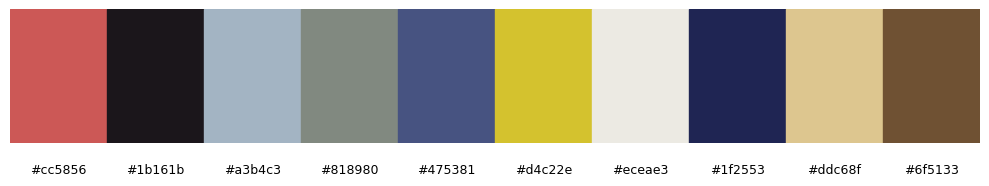

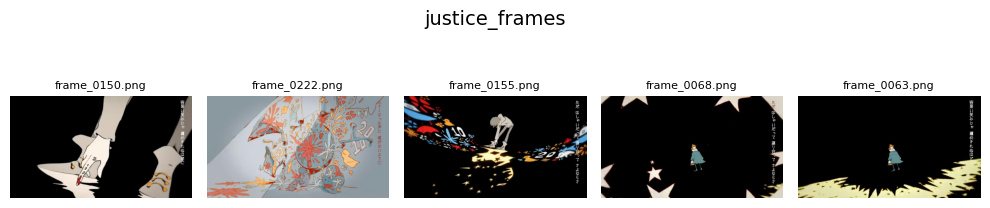

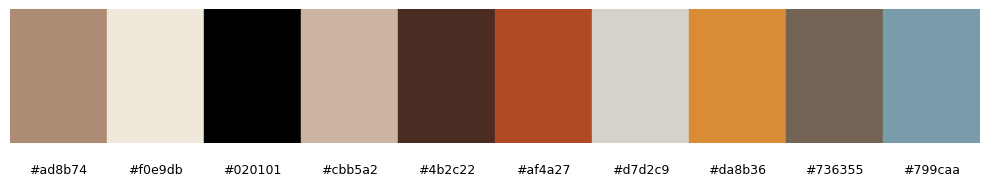

In [86]:
import matplotlib.pyplot as plt

def plot_palette(palette):
    swatch_size = 100
    n = len(palette)
    fig, ax = plt.subplots(figsize=(n, 2))
    
    for i, color in enumerate(palette):
        rgb = tuple(int(c) for c in color)
        hex_val = '#%02x%02x%02x' % rgb
        rect = plt.Rectangle((i, 0), 1, 1, color=np.array(rgb)/255)
        ax.add_patch(rect)
        ax.text(i + 0.5, -0.15, str(hex_val), ha='center', va='top', fontsize=9)

    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def display_thumbnails(image_paths, title=None):
    n = len(image_paths)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2.5))

    if title:
        fig.suptitle(title, fontsize=14)

    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(0, len(final_palettes)):
    display_thumbnails(mv_repr_paths[i], title=f"{frame_dirs[i]}")
    plot_palette(final_palettes[i])

Merged palette


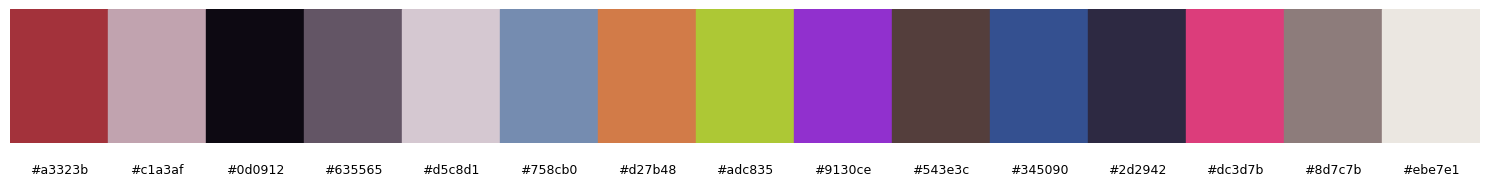

In [74]:
# Flatten all colors into a single list
all_video_colors = np.vstack(final_palettes)

k = 15

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(all_video_colors)
merged_palette = kmeans.cluster_centers_.astype(int)

print("Merged palette")
plot_palette(merged_palette)